In [1]:
from gc import enable

from google.cloud import bigquery
from google.cloud import bigquery_storage
creds = "/Users/srdeo/OneDrive - Copart, Inc/secrets/cprtpr-datastewards-sp1-614d7e297848 (1).json"
client = bigquery.Client.from_service_account_json(json_credentials_path=creds)
bqstorageclient = bigquery_storage.BigQueryReadClient(credentials=creds)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [5]:
import pandas as pd
import warnings

warnings.filterwarnings("ignore")

### High Level Steps:
1. March, April, May data will be used to train the model.
2. We will divide this data into training and testing sets. (75-25 split for training and validation)
3. June data will be used to test the model.
4. Churn Definition: If a PM has not placed any bid in the month of June, they are considered churned.

### Independent Variables:
* PMs who placed at least one bid for the lots sold in March and April.

### Dependent Variable:
* Churned or Not Churned (1 or 0) - If a PM has not placed any bid in the month of May, they are considered churned.

* Importing the data from BigQuery

In [2]:
## List of all PMs who participated in an auction for the lots sold in March and April

query1 = """
select distinct m.owner_mbr_nbr, m.mbr_nbr, count(distinct a.auc_id) as auc_joined_MarApril, avg(b.bid_amt) as avg_bid, m.mbr_state, m.lots_won, m.lots_bid, m.aucs_joined, m.member_sgmnt_type
from `cprtpr-dataplatform-sp1.usviews.v_us_lot_fact` l
join `cprtpr-dataplatform-sp1`.usviews.v_us_lot_auction_fact_ads a
on l.lot_nbr = a.lot_nbr
join `cprtpr-dataplatform-sp1.usviews.v_us_member_fact` m
on a.buyer_nbr = m.mbr_nbr
    join `cprtpr-dataplatform-sp1.usviews.v_us_bids_fact` b
    on b.auc_id = a.auc_id
where l.inv_dt is not null and l.inv_dt between '2025-03-01' and '2025-04-30'
group by m.owner_mbr_nbr, m.mbr_nbr, mbr_last_purchase_dt, m.mbr_state, m.lots_won, m.lots_bid, m.aucs_joined, m.member_sgmnt_type
"""

data1 = client.query(query1).to_dataframe()

In [66]:
data1
print(data1.shape)
print(data1.isnull().sum())

,owner_mbr_nbr,mbr_nbr,total_auc_may,avg_bid,mbr_last_purchase_dt,mbr_state,lots_won,lots_bid,aucs_joined,member_sgmnt_type
0,113528,113528,2,2592.066904,2025-06-24,DF,10,29,22,Exporter
1,502339,502339,1,3652.818304,2025-05-02,ID,6,219,83,Consumer
2,474118,474118,1,4038.508248,2025-05-22,ID,7,16,20,Consumer
3,521807,521807,1,3789.193195,2025-05-27,CT,1,5,3,Consumer
4,620532,620532,7,4688.658508,2025-06-19,CZ,70,757,175,Exporter
...,...,...,...,...,...,...,...,...,...,...
40612,830533,648483,5,4019.538658,2025-06-25,WI,34,902,152,Dealer
40613,337047,337047,2,7709.256063,2025-06-25,WI,17,84,46,Dealer
40614,16000,16000,1,3849.421228,2025-05-29,WI,1,8,5,Consumer
40615,443552,216577,2,4243.324368,2025-06-12,WI,25,160,109,Dealer


(40617, 10)
owner_mbr_nbr             0
mbr_nbr                   0
total_auc_may             0
avg_bid                   0
mbr_last_purchase_dt      0
mbr_state                 0
lots_won                  0
lots_bid                  1
aucs_joined               1
member_sgmnt_type       197
dtype: int64


In [67]:
## Below query gives us all PMs who lapsed premier membership in the June

query2 = """
select * from `cprtpr-dataplatform-sp1`.usviews.v_us_member_events_fact
where event_type = 'Member Last Lapsed Premier Date'
and event_value between '2025-06-01' and '2025-06-26'
"""

data2 = client.query(query2).to_dataframe()

In [68]:
data2

,mbr_nbr,event_type,event_value,pri_ref_id,pri_ref_type
0,289638,Member Last Lapsed Premier Date,2025-06-01 00:33:11+00:00,<NA>,None
1,337166,Member Last Lapsed Premier Date,2025-06-01 10:00:02+00:00,<NA>,None
2,283892,Member Last Lapsed Premier Date,2025-06-01 10:00:02+00:00,<NA>,None
3,240350,Member Last Lapsed Premier Date,2025-06-01 10:00:02+00:00,<NA>,None
4,564808,Member Last Lapsed Premier Date,2025-06-01 10:00:02+00:00,<NA>,None
...,...,...,...,...,...
4051,172372,Member Last Lapsed Premier Date,2025-06-16 21:56:15+00:00,<NA>,None
4052,114276,Member Last Lapsed Premier Date,2025-06-09 16:43:24+00:00,<NA>,None
4053,116272,Member Last Lapsed Premier Date,2025-06-19 20:41:00+00:00,<NA>,None
4054,112505,Member Last Lapsed Premier Date,2025-06-05 19:28:22+00:00,<NA>,None


In [69]:
mbr_nbr = data2['mbr_nbr'].unique()

In [70]:
master_df = data1.copy()

master_df['churn'] = master_df['mbr_nbr'].isin(mbr_nbr).astype(int)

In [71]:
master_df
print(master_df.shape)
print(master_df.isnull().sum())
master_df['churn'].value_counts()

,owner_mbr_nbr,mbr_nbr,total_auc_may,avg_bid,mbr_last_purchase_dt,mbr_state,lots_won,lots_bid,aucs_joined,member_sgmnt_type,churn
0,113528,113528,2,2592.066904,2025-06-24,DF,10,29,22,Exporter,0
1,502339,502339,1,3652.818304,2025-05-02,ID,6,219,83,Consumer,0
2,474118,474118,1,4038.508248,2025-05-22,ID,7,16,20,Consumer,0
3,521807,521807,1,3789.193195,2025-05-27,CT,1,5,3,Consumer,0
4,620532,620532,7,4688.658508,2025-06-19,CZ,70,757,175,Exporter,0
...,...,...,...,...,...,...,...,...,...,...,...
40612,830533,648483,5,4019.538658,2025-06-25,WI,34,902,152,Dealer,0
40613,337047,337047,2,7709.256063,2025-06-25,WI,17,84,46,Dealer,0
40614,16000,16000,1,3849.421228,2025-05-29,WI,1,8,5,Consumer,0
40615,443552,216577,2,4243.324368,2025-06-12,WI,25,160,109,Dealer,0


(40617, 11)
owner_mbr_nbr             0
mbr_nbr                   0
total_auc_may             0
avg_bid                   0
mbr_last_purchase_dt      0
mbr_state                 0
lots_won                  0
lots_bid                  1
aucs_joined               1
member_sgmnt_type       197
churn                     0
dtype: int64


churn
0    40411
1      206
Name: count, dtype: int64

In [72]:
## Adding days since last purchase

master_df['days_since_last_purchase'] = (pd.to_datetime('2025-06-26') - pd.to_datetime(master_df['mbr_last_purchase_dt'])).dt.days

In [73]:
master_df

,owner_mbr_nbr,mbr_nbr,total_auc_may,avg_bid,mbr_last_purchase_dt,mbr_state,lots_won,lots_bid,aucs_joined,member_sgmnt_type,churn,days_since_last_purchase
0,113528,113528,2,2592.066904,2025-06-24,DF,10,29,22,Exporter,0,2
1,502339,502339,1,3652.818304,2025-05-02,ID,6,219,83,Consumer,0,55
2,474118,474118,1,4038.508248,2025-05-22,ID,7,16,20,Consumer,0,35
3,521807,521807,1,3789.193195,2025-05-27,CT,1,5,3,Consumer,0,30
4,620532,620532,7,4688.658508,2025-06-19,CZ,70,757,175,Exporter,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...
40612,830533,648483,5,4019.538658,2025-06-25,WI,34,902,152,Dealer,0,1
40613,337047,337047,2,7709.256063,2025-06-25,WI,17,84,46,Dealer,0,1
40614,16000,16000,1,3849.421228,2025-05-29,WI,1,8,5,Consumer,0,28
40615,443552,216577,2,4243.324368,2025-06-12,WI,25,160,109,Dealer,0,14


In [49]:
master_df.groupby('churn')['member_sgmnt_type'].value_counts()

churn  member_sgmnt_type
0      Exporter             11569
       Dealer               11205
       Consumer             10363
       Dismantler            6139
       General Business       938
1      Dealer                  64
       Consumer                61
       Exporter                53
       Dismantler              25
       General Business         3
Name: count, dtype: int64

* Most of the Churned PMs are Dealers

In [76]:
## remove redundant columns

master_df = master_df.drop(columns=['mbr_last_purchase_dt', 'mbr_nbr', 'owner_mbr_nbr'])

In [77]:
master_df

,total_auc_may,avg_bid,mbr_state,lots_won,lots_bid,aucs_joined,member_sgmnt_type,churn,days_since_last_purchase
0,2,2592.066904,DF,10,29,22,Exporter,0,2
1,1,3652.818304,ID,6,219,83,Consumer,0,55
2,1,4038.508248,ID,7,16,20,Consumer,0,35
3,1,3789.193195,CT,1,5,3,Consumer,0,30
4,7,4688.658508,CZ,70,757,175,Exporter,0,7
...,...,...,...,...,...,...,...,...,...
40612,5,4019.538658,WI,34,902,152,Dealer,0,1
40613,2,7709.256063,WI,17,84,46,Dealer,0,1
40614,1,3849.421228,WI,1,8,5,Consumer,0,28
40615,2,4243.324368,WI,25,160,109,Dealer,0,14


In [83]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
import shap

In [91]:
for col in master_df.select_dtypes(include='object').columns:
    master_df[col] = master_df[col].astype('category')

In [92]:
X = master_df.drop('churn', axis=1)
y = master_df['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)


In [93]:
imbalance_ratio = (y_train == 0).sum() / (y_train == 1).sum()

# Train XGBoost with native categorical handling
model = XGBClassifier(tree_method='hist',
                      enable_categorical=True,
                      scale_pos_weight=imbalance_ratio,
                      use_label_encoder=False,
                      eval_metric='logloss',
                      random_state=42)
model.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,True
,eval_metric,'logloss'


In [94]:
y_pred = model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     10103
           1       0.07      0.02      0.03        52

    accuracy                           0.99     10155
   macro avg       0.53      0.51      0.51     10155
weighted avg       0.99      0.99      0.99     10155



In [96]:
from sklearn.preprocessing import LabelEncoder

X_shap = X_test.copy()

for col in X_shap.select_dtypes(include='category').columns:
    le = LabelEncoder()
    X_shap[col] = le.fit_transform(X_shap[col])


In [97]:
explainer = shap.Explainer(model)
shap_values = explainer(X_shap)


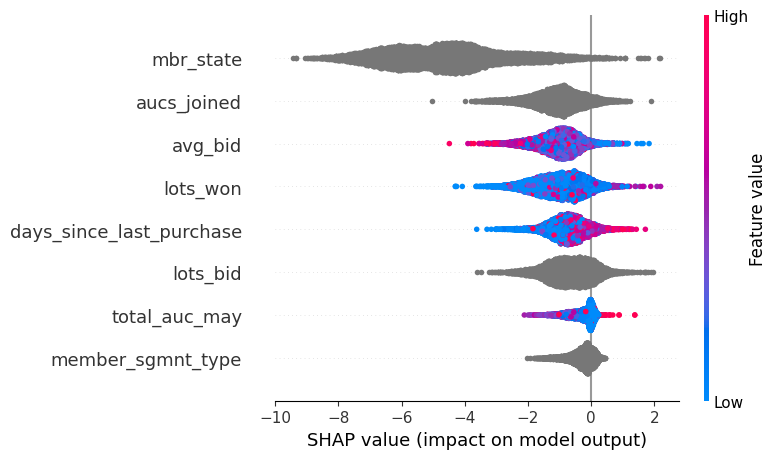

In [98]:
›shap.summary_plot(shap_values, X_test)